In [1]:
!pip install statsforecast skforecast --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 6.4 MB/s eta 0:00:00


In [40]:
# One-Step vs Multi-Step Forecast Comparison Script
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [107]:
# Get period_end and followers numbers
df = pd.read_csv("/content/followers.csv",
                 usecols=[1, 5],
                 header=0,
                 names=['ds', 'y'],
                 parse_dates=['ds'])

# Add Unique ID for StatsForecast format
df['unique_id'] = 'followers'

# Sort
df.sort_values(by='ds', inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop last row, as the month was not complete yet
df.drop(df.tail(1).index[0], axis=0, inplace=True)
df

,ds,y,unique_id
0,2020-07-31,2,followers
1,2020-08-31,18,followers
2,2020-09-30,32,followers
3,2020-10-31,39,followers
4,2020-11-30,55,followers
...,...,...,...
58,2025-05-31,3210,followers
59,2025-06-30,3245,followers
60,2025-07-31,3345,followers
61,2025-08-31,3403,followers


# Let's follow Forecasting Principles Steps

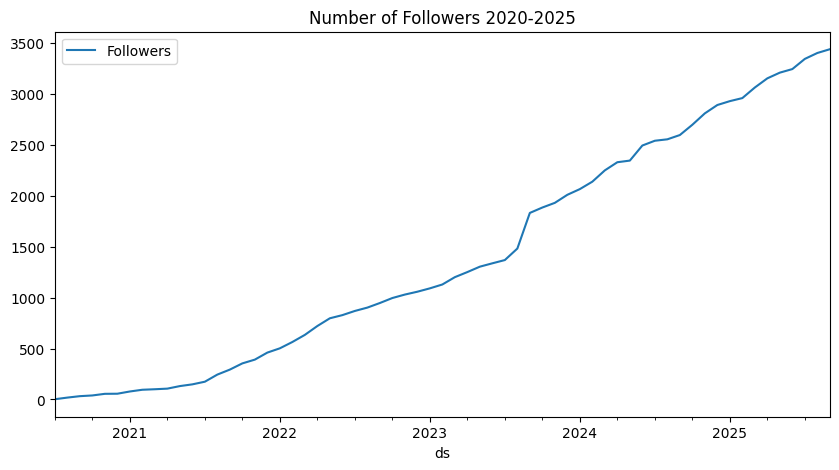

In [65]:
# 1. Plot the data
df.plot(x='ds', y='y',
        figsize=(10, 5),
        label='Followers',
        title='Number of Followers 2020-2025');

In [66]:
# 2. Check if data is stationary

# ADF Test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(' %s: %.3f' % (key, value))


print("ADF Test Results:\n")
adf_test(df['y'])

ADF Test Results:

ADF Statistic: 2.476353
p-value: 0.999042
Critical Values:
 1%: -3.541
 5%: -2.909
 10%: -2.592


In [67]:
# Let's make the series stationary with one differencing.
adf_test(df['y'].diff().dropna())

ADF Statistic: -5.049668
p-value: 0.000018
Critical Values:
 1%: -3.544
 5%: -2.911
 10%: -2.593


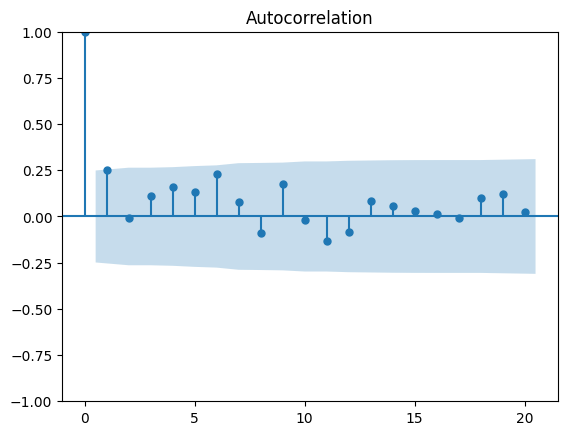

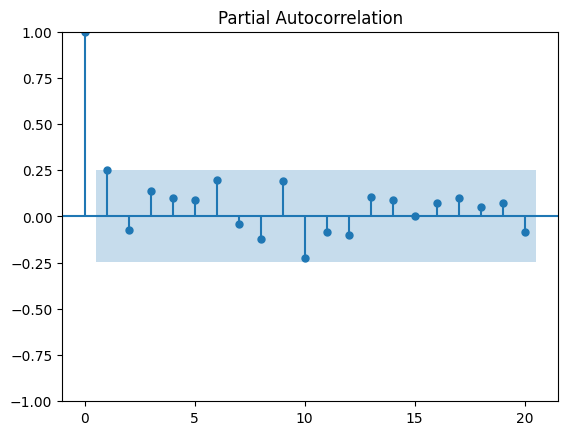

In [68]:
# 3. Let's examine the ACF and PACF plots

plot_acf(df['y'].diff().dropna(), lags=20)
plt.show()

plot_pacf(df['y'].diff().dropna(), lags=20)
plt.show()

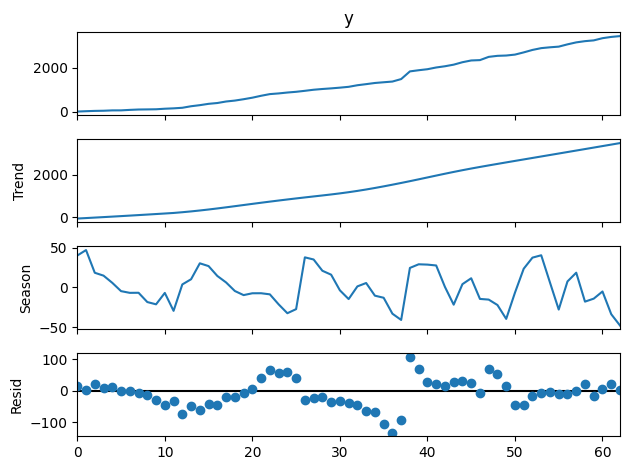

In [69]:
# Season Trend with Loess decomposition
stl = STL(df['y'], period=12)
res = stl.fit()

res.plot().show()

In [108]:
# How many periods is the test set?
test_periods = 6

# Train test split
split = len(df) - test_periods

# Split train and test
train1 = df.iloc[:split]
test1 = df.iloc[split:]

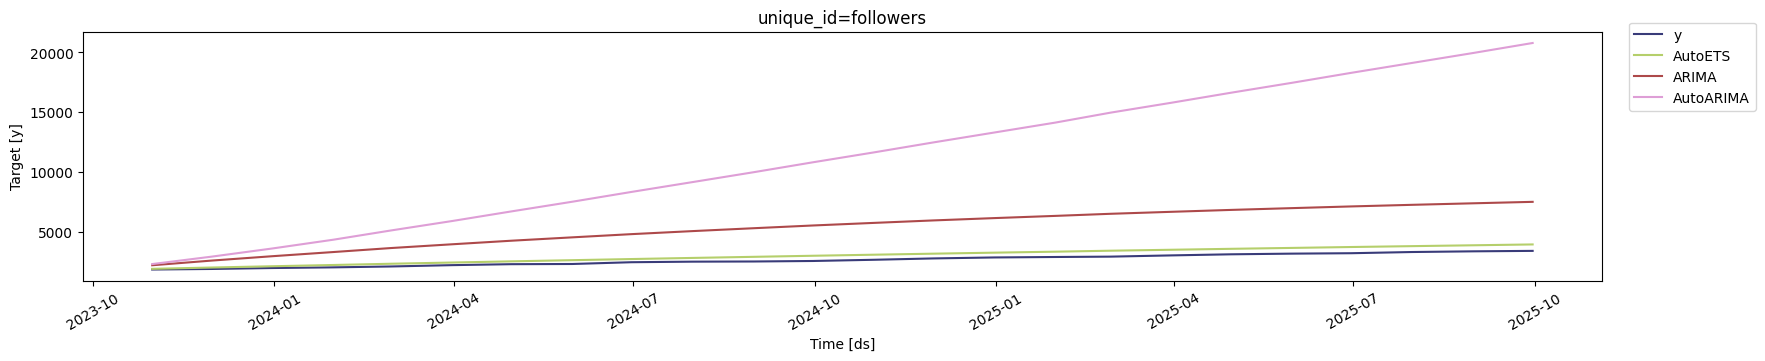

In [110]:
# 4. Model ARIMA
# Looking at the PACF, it appears that a (1,0,0) model would be appropriate.

# Model chosen
models = [AutoETS(),
          ARIMA(order=(1,1,1)),
          AutoARIMA(seasonal=False)]

# Instantiate
sf = StatsForecast(
    models= models,
    freq= 'ME'
)

# Fit
sf.fit(train1)

# Predict the next 6 months and 95% confidence interval
forecasts = sf.predict(h=24, level=[95])

# Plot series
sf.plot(df= test1,
        forecasts_df=forecasts
        )


In [111]:
from statsforecast.arima import ARIMASummary
ARIMASummary(sf.fitted_[0, 1].model_)

ARIMA(1,1,1)                   

### Testing and Evaluating

In [113]:
test2 = test1.reset_index(drop=True).copy()
test2['AutoArima'] = forecasts['AutoARIMA']
test2['Arima'] = forecasts['ARIMA']
test2['AutoETS'] = forecasts['AutoETS']
test2.sample(4)

,ds,y,unique_id,AutoArima,Arima,AutoETS
17,2025-03-31,3064,followers,15800.730469,6699.551758,3533.711182
10,2024-08-31,2555,followers,10001.703125,5329.938965,2943.467529
6,2024-04-30,2330,followers,6728.476562,4286.304688,2566.758545
19,2025-05-31,3210,followers,17460.363281,7006.176270,3687.579102


#### AIC and MAPE

In [114]:
# Collecting Metrics
summaries = []
for model in sf.fitted_[0]:
  summary_model = {
        "model": model,
        "loglik": model.model_['loglik'],
        "AIC": model.model_['aic'],
        "BIC": model.model_['bic']
    }
  summaries.append(summary_model)

# DataFrame
pd.DataFrame(summaries)

,model,loglik,AIC,BIC
0,AutoETS,-200.649762,413.299524,423.280894
1,ARIMA,-197.769930,401.539861,406.452619
2,AutoARIMA,-189.686364,383.372728,386.594564


In [115]:
print(f"ETS: {mean_absolute_percentage_error(test2['y'], test2['AutoETS'])}")
print(f"ARIMA: {mean_absolute_percentage_error(test2['y'], test2['Arima'])}")
print(f"AutoARIMA: {mean_absolute_percentage_error(test2['y'], test2['AutoArima'])}")

ETS: 0.1275806874036789
ARIMA: 0.9656335711479187
AutoARIMA: 2.969238042831421


In [117]:
# Checking if residuals are independent
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljun-Box Q Test
# Ho - No residuals correlation. Good fit of the model.
# Ha - There is correlation/ pattern in the residuals. Not the best fit.
print('Residuals check: ETS')
print( acorr_ljungbox(
    sf.fitted_[0][0].model_['residuals'],
    lags=[24],
    model_df=2) )
print('----------------------\n')

print('Residuals check: ARIMA(1,1,1)')
print( acorr_ljungbox(
    sf.fitted_[0][0].model_['residuals'],
    lags=[24],
    model_df=2) )
print('----------------------\n')

print('Residuals check: AutoARIMA(0,2,1)')
print( acorr_ljungbox(
    sf.fitted_[0][1].model_['residuals'],
    lags=[24],
    model_df=2) )
print('----------------------\n')

Residuals check: ETS
     lb_stat  lb_pvalue
24  18.20203   0.693945
----------------------

Residuals check: ARIMA(1,1,1)
     lb_stat  lb_pvalue
24  18.20203   0.693945
----------------------

Residuals check: AutoARIMA(0,2,1)
     lb_stat  lb_pvalue
24  9.047543    0.99308
----------------------



## Direct Multi-Step Forecast

In [77]:
from skforecast.direct import ForecasterDirect
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [118]:
# Get period_end and followers numbers
df2 = pd.read_csv("/content/followers.csv",
                 usecols=[1, 5],
                 header=0,
                 names=['ds', 'y'],
                 parse_dates=['ds'],
                 index_col='ds')
df2.sort_index(inplace=True)

# Drop last row, as the month was not complete yet
df.drop(df.tail(1).index[0], axis=0, inplace=True)

df2.index.freq = 'ME'

data = pd.Series(df2.y, index=df2.index)
data.head()

,y
ds,
2020-07-31,2
2020-08-31,18
2020-09-30,32
2020-10-31,39
2020-11-30,55


In [119]:
# How many periods is the test set?
test_periods = 6

# Train test split
split = len(df) - test_periods

# Split train and test
train = data.iloc[:split]
test = data.iloc[split:]

In [124]:
# Direct model
forecaster = ForecasterDirect(
  regressor=Ridge(alpha=0.1),
  lags=6,
  steps=test_periods,
  differentiation=1
)

forecaster.fit(y=train)
forecaster

================ 
ForecasterDirect 
================ 
Regressor: Ridge 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 7 
Maximum steps to predict: 24 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [Timestamp('2020-07-31 00:00:00'), Timestamp('2023-10-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: ME 
Regressor parameters: 
    {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-10-24 01:48:28 
Last fit date: 2025-10-24 01:48:28 
Skforecast version: 0.18.0 
Python version: 3.12.12 
Forecaster id: None

In [125]:
# Predict
predictions = forecaster.predict()
predictions.head()

,pred
2023-11-30,2040.747428
2023-12-31,2157.574867
2024-01-31,2301.287800
2024-02-29,2339.249088
2024-03-31,2481.773308


In [126]:
test2 = test1.reset_index(drop=True).copy()
test2['AutoArima'] = forecasts['AutoARIMA']
test2['Arima'] = forecasts['ARIMA']
test2['AutoETS'] = forecasts['AutoETS']
test2['direct'] = predictions.reset_index(drop=True)
test2.set_index('ds', inplace=True)
test2.head()

,y,unique_id,AutoArima,Arima,AutoETS,direct
ds,,,,,,
2023-10-31,1885,followers,2340.662354,2240.771973,1941.420654,2040.747428
2023-11-30,1931,followers,2955.543213,2628.431885,2050.977539,2157.574867
2023-12-31,2010,followers,3641.533447,2996.070312,2158.343262,2301.287800
2024-01-31,2066,followers,4375.128418,3344.721191,2263.561768,2339.249088
2024-02-29,2139,followers,5140.592773,3675.365234,2366.675781,2481.773308


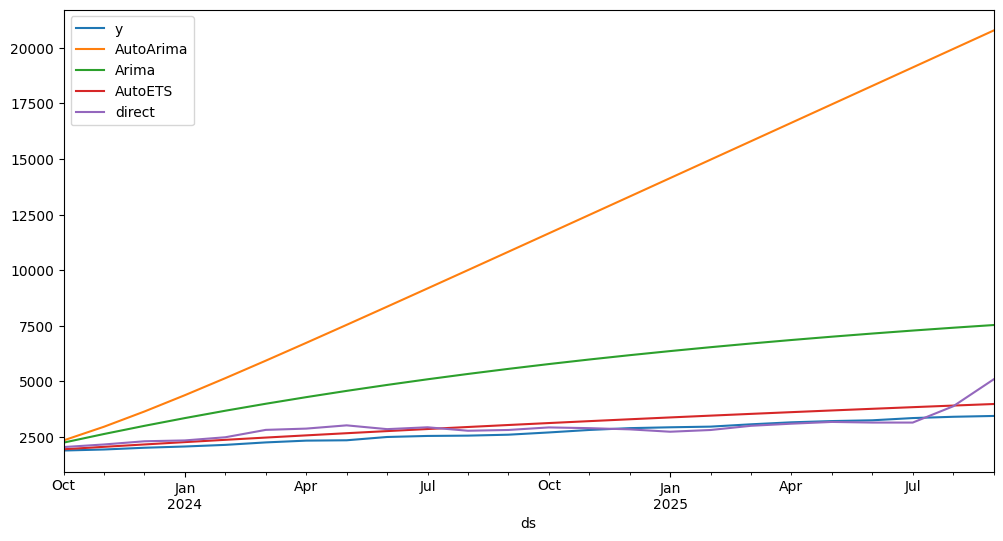

In [127]:
# Plot the comparison
test2.plot(figsize=(12,6));

In [128]:
print(f"ETS: {mean_absolute_percentage_error(test2['y'], test2['AutoETS'])}")
print(f"ARIMA: {mean_absolute_percentage_error(test2['y'], test2['Arima'])}")
print(f"AutoARIMA: {mean_absolute_percentage_error(test2['y'], test2['AutoArima'])}")
print(f"Direct: {mean_absolute_percentage_error(test2['y'], test2['direct'])}")

ETS: 0.1275806874036789
ARIMA: 0.9656335711479187
AutoARIMA: 2.969238042831421
Direct: 0.12009286363917777


## Long Period forecast.
Change the `test_periods` variable to 24 months and rerun all the cells.